In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [7]:
task = "pmd"
# model_root_and_name_tuple_list = []
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("sequnet_dunham", "sequnet"), ("vespa_marquet", "vespa"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("dbnsfp", "integrated_fitCons"), ("dbnsfp", "phyloP17way_primate"), ("dbnsfp", "phastCons17way_primate"), ("dbnsfp", "bStatistic"),
                                  ("", "random_classifier"), ]


# by default, we consider larger means positive class (here Effect), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [18]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.tsv", sep="\t")
print(result_df.shape)
print(result_df.columns)
result_df.rename(columns={"functional_effect": "class"}, inplace=True)
result_df["class"].value_counts()

(60306, 58)
Index(['mut_id', 'pmd_id', 'nr', 'crossref', 'uniprot_id', 'ensembl_id',
       'taxid', 'protein', 'mut_PMD', 'mut_real', 'wt', 'mut', 'prot_pos',
       'function_summarized', 'functional_effect', 'function', 'seq', 'snp_id',
       'mrna_acc', 'mrna_ver', 'mrna_pos', 'allele', 'protein_acc',
       'protein_ver', 'verified', 'chrom', 'chrom_pos', 'variation',
       'variant_type', 'ref_allele', 'alt_allele', 'pmd_nr_id', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'sequnet_pred', 'vespa_pred', 'unirep_pred',
       'protbert_pred', 'esm1b_t33_650M_UR50S_pred',
       'esm1v_t33_650M_UR90S_pred', 'esm2_t33_650M_UR50D_pred',
       'plus_rnn_pred', 'prottrans_bert_bfd_pred', 'prottrans_albert_bfd_pred',
       'prottrans_xlnet_uniref100_pred', 'prottrans_t5_bfd_pred',
       'prottrans_t5_uniref50_pred', 'prottrans_t5_xl_u50_pred',
       'integrated_fitCons_pred', 'phyloP17way_primate_pred',
       'phastCons17

Effect       30774
No-effect    15442
Knock-out    14090
Name: class, dtype: int64

### The following are the helper functions that computes the performance metrics for human and non-human analysis

In [9]:
def get_non_nan_df(df, col_name, positive_cls, negative_cls):
    df = df[(df["class"]==positive_cls) | (df["class"]==negative_cls)]
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df, positive_cls, negative_cls, n_samples):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls]
    negative_cls_result_df = df[df["class"]==negative_cls]
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0

    positive_cls_result_df = positive_cls_result_df.sample(n=min(n_samples, positive_cls_result_df.shape[0]))
    negative_cls_result_df = negative_cls_result_df.sample(n=min(n_samples, negative_cls_result_df.shape[0]))

    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

def compute_all_methods_all_metics(result_df, positive_cls, negative_cls, n_samples, is_dbnsfp_ok):
    performance_scores_dict = {}
    for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
        print(model_name)
        if model_root=="dbnsfp" and not is_dbnsfp_ok: continue

        model_pred_col = model_name + "_pred"
        performance_scores = []

        for i_run in range(10): #10 runs
            if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]

            non_nan_result_df, missing_values_percentage = get_non_nan_df(result_df, model_pred_col, positive_cls, negative_cls)

            sampled_result_df = sample_positive_and_negative_data_points(non_nan_result_df, positive_cls, negative_cls, n_samples)
            
            sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
            
            non_nan_result_df = sampled_result_df
            non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
            
            ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
            auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
            f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
            precision = get_precision_score(non_nan_result_df, th_max)
            recall = get_recall_score(non_nan_result_df, th_max)
            accuracy = get_accuracy_score(non_nan_result_df, th_max)
            balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
            mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
            
            performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage])
            print()
            
        performance_scores_dict[model_name] = performance_scores
    return performance_scores_dict

In [10]:
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.tsv"

def write_metrics_outputs(performance_scores_dict, output_file):
    out = open(output_file, 'w')
    out.write("Models\\Metrics")
    for metric in metrics:
        out.write(f"\t{metric}")
    out.write("\n")

    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")
        for scores in performance_scores:
            for score in scores:
                out.write(f"\t{score:.3f}")
            out.write("\n")
        out.write("\n")
        
    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")    
        avg_scores = np.mean(performance_scores, axis=0)
        std_scores = np.std(performance_scores, axis=0)
        for i in range(len(avg_scores)):
            out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
        out.write("\n")
    out.close()

### Human: Effect vs. No-effect and Knock-out vs. No-effect

In [19]:
# print("#-human (taxid)", result_df[result_df["taxid"]=="9606"].shape) # # number of human entries using taxid: 14072. no longer using this.
human_result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
print(human_result_df.shape)

positive_cls = "Effect" # Effect, Knock-out
negative_cls = "No-effect" 

human_result_df = human_result_df[(human_result_df['class']==negative_cls) | (human_result_df['class']==positive_cls)]
human_result_df["class"].value_counts()

# only keeping rows that have at least 4 supervised prediction scores.
# the empty rows are populated with the median values of that colum
filtered_result_df = human_result_df[human_result_df["n_methods_having_preds"]>=4]
print(filtered_result_df["class"].value_counts())

missing_value_percentage_dict = {}
for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        missing_value_percentage_dict[model_pred_col] = 0.0
        continue
    # model_pred_col = "esm1b_t33_650M_UR50S_pred"
    median = filtered_result_df[model_pred_col].median()
    nan_value_rows = filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape[0]
    missing_value_percentage_dict[model_pred_col] = 100*(nan_value_rows / human_result_df.shape[0])
    print("\tnan value rows:", nan_value_rows)
    if nan_value_rows>0:
        filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col]), model_pred_col] = median
    print("\tafter populating nan value rows with median:", filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape)
    # break
human_result_df = filtered_result_df
human_result_df["class"].value_counts()


(16894, 58)
Effect       1388
No-effect     314
Name: class, dtype: int64
sift
	nan value rows: 43
	after populating nan value rows with median: (0, 58)
polyphen2_HVAR
	nan value rows: 42
	after populating nan value rows with median: (0, 58)
cadd
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
mvp
	nan value rows: 122
	after populating nan value rows with median: (0, 58)
metarnn
	nan value rows: 19
	after populating nan value rows with median: (0, 58)
revel
	nan value rows: 39
	after populating nan value rows with median: (0, 58)
sequnet
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
vespa
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
unirep
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
protbert
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
esm1b_t33_650M_UR50S
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
esm1v_t33_650M_UR90S
	n

Effect       1388
No-effect     314
Name: class, dtype: int64

In [13]:
performance_scores_dict = compute_all_methods_all_metics(human_result_df, positive_cls, negative_cls, n_samples=3000, is_dbnsfp_ok=True)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_human_{positive_cls}_vs_{negative_cls}_analysis.tsv")

sift
	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.629
	KS-test score. statistic: 0.234, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.629
	KS-test score. statistic: 0.234, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.629
	KS-test score. statistic: 0.234,

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-ROC: 0.629
	KS-test score. statistic: 0.234, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.629
	KS-test score. statistic: 0.234, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.629
	KS-test score. statistic: 0.234, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.898 at threshold: -1.000
	Precision scor

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.621
	KS-test score. statistic: 0.216, p-value: 0.000
	AUC-PR: 0.874
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.621
	KS-test score. statistic: 0.216, p-value: 0.000
	AUC-PR: 0.874
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-ROC: 0.621
	KS-test score. statistic: 0.216, p-value: 0.000
	AUC-PR: 0.874
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

cadd
	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values:

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-ROC: 0.549
	KS-test score. statistic: 0.177, p-value: 0.000
	AUC-PR: 0.820
	Best F1-Score: 0.898 at threshold: 0.401
	Precision score: 0.828 at threshold: 0.401
	Recall score: 0.982 at threshold: 0.401
	Accuracy score: 0.819 at threshold: 0.401
	Balanced accuracy score: 0.540 at threshold: 0.401
	MCC score: 0.176 at threshold: 0.401

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.549
	KS-test score. statistic: 0.177, p-value: 0.000
	AUC-PR: 0.820
	Best F1-Score: 0.898 at threshold: 0.401
	Precision score: 0.828 at threshold: 0.401
	Recall score: 0.982 at threshold: 0.401
	Accuracy score: 0.819 at threshold: 0.401
	Balanced accuracy score: 0.540 at threshold: 0.401
	MCC score: 0.176 at threshold: 0.401

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.549
	KS-test score. statistic: 0.177, p-value: 0.000
	AUC-PR: 0.820
	Best F1-Score: 0.898 at threshold: 0.401
	Precision score: 0.828 at t

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	MCC score: 0.176 at threshold: 0.401

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.549
	KS-test score. statistic: 0.177, p-value: 0.000
	AUC-PR: 0.820
	Best F1-Score: 0.898 at threshold: 0.401
	Precision score: 0.828 at threshold: 0.401
	Recall score: 0.982 at threshold: 0.401
	Accuracy score: 0.819 at threshold: 0.401
	Balanced accuracy score: 0.540 at threshold: 0.401
	MCC score: 0.176 at threshold: 0.401

metarnn
	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.653
	KS-test score. statistic: 0.317, p-value: 0.000
	AUC-PR: 0.872
	Best F1-Score: 0.899 at threshold: 0.000
	Precision score: 0.817 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.058 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.653
	KS

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	KS-test score. statistic: 0.317, p-value: 0.000
	AUC-PR: 0.872
	Best F1-Score: 0.899 at threshold: 0.000
	Precision score: 0.817 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.058 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.653
	KS-test score. statistic: 0.317, p-value: 0.000
	AUC-PR: 0.872
	Best F1-Score: 0.899 at threshold: 0.000
	Precision score: 0.817 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.058 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.653
	KS-test score. statistic: 0.317, p-value: 0.000
	AUC-PR: 0.872
	Best F1-Score: 0.899 at threshold: 0.000
	Precision score: 0.817 at threshold: 0.000


/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.665
	KS-test score. statistic: 0.322, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.665
	KS-test score. statistic: 0.322, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.665
	KS-test sc

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-PR: 0.880
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.665
	KS-test score. statistic: 0.322, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

sequnet
	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.077, p-value: 0.088
	AUC-PR: 0.827
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000


/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.077, p-value: 0.088
	AUC-PR: 0.827
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.077, p-value: 0.088
	AUC-PR: 0.827
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.077, p-value: 0.088
	AUC-PR: 0.827
	Best F1-Score: 0.

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.085, p-value: 0.045
	AUC-PR: 0.824
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.085, p-value: 0.045
	AUC-PR: 0.824
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values:

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.085, p-value: 0.045
	AUC-PR: 0.824
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

unirep
	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.451
	KS-test score. statistic: 0.113, p-value: 0.003
	AUC-PR: 0.853
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy sco

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.451
	KS-test score. statistic: 0.113, p-value: 0.003
	AUC-PR: 0.853
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.451
	KS-test score. statistic: 0.113, p-value: 0.003
	AUC-PR: 0.853
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.451
	KS-test score. statistic: 0.113, p-value: 0.003
	AUC-PR: 0.853
	Best 

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Accuracy score: 0.817 at threshold: -0.896
	Balanced accuracy score: 0.503 at threshold: -0.896
	MCC score: 0.072 at threshold: -0.896

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.056, p-value: 0.372
	AUC-PR: 0.822
	Best F1-Score: 0.899 at threshold: -0.896
	Precision score: 0.816 at threshold: -0.896
	Recall score: 1.000 at threshold: -0.896
	Accuracy score: 0.817 at threshold: -0.896
	Balanced accuracy score: 0.503 at threshold: -0.896
	MCC score: 0.072 at threshold: -0.896

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.056, p-value: 0.372
	AUC-PR: 0.822
	Best F1-Score: 0.899 at threshold: -0.896
	Precision score: 0.816 at threshold: -0.896
	Recall score: 1.000 at threshold: -0.896
	Accuracy score: 0.817 at threshold: -0.896
	Balanced accuracy score: 0.503 at threshold: -0.896
	MCC score: 0.072 at threshold: -0.896

	

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-PR: 0.822
	Best F1-Score: 0.899 at threshold: -0.896
	Precision score: 0.816 at threshold: -0.896
	Recall score: 1.000 at threshold: -0.896
	Accuracy score: 0.817 at threshold: -0.896
	Balanced accuracy score: 0.503 at threshold: -0.896
	MCC score: 0.072 at threshold: -0.896

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.056, p-value: 0.372
	AUC-PR: 0.822
	Best F1-Score: 0.899 at threshold: -0.896
	Precision score: 0.816 at threshold: -0.896
	Recall score: 1.000 at threshold: -0.896
	Accuracy score: 0.817 at threshold: -0.896
	Balanced accuracy score: 0.503 at threshold: -0.896
	MCC score: 0.072 at threshold: -0.896

esm1b_t33_650M_UR50S
	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.327
	KS-test score. statistic: 0.278, p-value: 0.000
	AUC-PR: 0.889
	Best F1-Score: 0.899 at threshold: -0.942
	Precision score: 0.817 at threshold: -0.942
	Recall score:

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-PR: 0.880
	Best F1-Score: 0.899 at threshold: -0.912
	Precision score: 0.817 at threshold: -0.912
	Recall score: 1.000 at threshold: -0.912
	Accuracy score: 0.817 at threshold: -0.912
	Balanced accuracy score: 0.505 at threshold: -0.912
	MCC score: 0.088 at threshold: -0.912

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.330
	KS-test score. statistic: 0.316, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.899 at threshold: -0.912
	Precision score: 0.817 at threshold: -0.912
	Recall score: 1.000 at threshold: -0.912
	Accuracy score: 0.817 at threshold: -0.912
	Balanced accuracy score: 0.505 at threshold: -0.912
	MCC score: 0.088 at threshold: -0.912

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.330
	KS-test score. statistic: 0.316, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.899 at threshold: -0.912
	Precision score: 0.817 at threshold: -0.912
	Recall score: 1.000 at threshold: 

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.330
	KS-test score. statistic: 0.316, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.899 at threshold: -0.912
	Precision score: 0.817 at threshold: -0.912
	Recall score: 1.000 at threshold: -0.912
	Accuracy score: 0.817 at threshold: -0.912
	Balanced accuracy score: 0.505 at threshold: -0.912
	MCC score: 0.088 at threshold: -0.912

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.330
	KS-test score. statistic: 0.316, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.899 at threshold: -0.912
	Precision score: 0.817 at threshold: -0.912
	Recall score: 1.000 at threshold: -0.912
	Accuracy score: 0.817 at threshold: -0.912
	Balanced accuracy score: 0.505 at threshold: -0.912
	MCC score: 0.088 at threshold: -0.912

esm2_t33_650M_UR50D
	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.353
	KS-test score. st

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Best F1-Score: 0.899 at threshold: -0.689
	Precision score: 0.819 at threshold: -0.689
	Recall score: 0.998 at threshold: -0.689
	Accuracy score: 0.818 at threshold: -0.689
	Balanced accuracy score: 0.510 at threshold: -0.689
	MCC score: 0.102 at threshold: -0.689

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.353
	KS-test score. statistic: 0.267, p-value: 0.000
	AUC-PR: 0.873
	Best F1-Score: 0.899 at threshold: -0.689
	Precision score: 0.819 at threshold: -0.689
	Recall score: 0.998 at threshold: -0.689
	Accuracy score: 0.818 at threshold: -0.689
	Balanced accuracy score: 0.510 at threshold: -0.689
	MCC score: 0.102 at threshold: -0.689

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.353
	KS-test score. statistic: 0.267, p-value: 0.000
	AUC-PR: 0.873
	Best F1-Score: 0.899 at threshold: -0.689
	Precision score: 0.819 at threshold: -0.689
	Recall score: 0.998 at threshold: -0.689
	Accurac

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.146, p-value: 0.000
	AUC-PR: 0.860
	Best F1-Score: 0.899 at threshold: -0.867
	Precision score: 0.816 at threshold: -0.867
	Recall score: 1.000 at threshold: -0.867
	Accuracy score: 0.817 at threshold: -0.867
	Balanced accuracy score: 0.503 at threshold: -0.867
	MCC score: 0.072 at threshold: -0.867

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.146, p-value: 0.000
	AUC-PR: 0.860
	Best F1-Score: 0.899 at threshold: -0.867
	Precision score: 0.816 at threshold: -0.867
	Recall score: 1.000 at threshold: -0.867
	Accuracy score: 0.817 at threshold: -0.867
	Balanced accuracy score: 0.503 at threshold: -0.867
	MCC score: 0.072 at threshold: -0.867

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.146, p-va

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Recall score: 1.000 at threshold: -0.867
	Accuracy score: 0.817 at threshold: -0.867
	Balanced accuracy score: 0.503 at threshold: -0.867
	MCC score: 0.072 at threshold: -0.867

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.146, p-value: 0.000
	AUC-PR: 0.860
	Best F1-Score: 0.899 at threshold: -0.867
	Precision score: 0.816 at threshold: -0.867
	Recall score: 1.000 at threshold: -0.867
	Accuracy score: 0.817 at threshold: -0.867
	Balanced accuracy score: 0.503 at threshold: -0.867
	MCC score: 0.072 at threshold: -0.867

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.146, p-value: 0.000
	AUC-PR: 0.860
	Best F1-Score: 0.899 at threshold: -0.867
	Precision score: 0.816 at threshold: -0.867
	Recall score: 1.000 at threshold: -0.867
	Accuracy score: 0.817 at threshold: -0.867
	Balanced accuracy score: 0.503 at threshold: -0.867

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-ROC: 0.349
	KS-test score. statistic: 0.267, p-value: 0.000
	AUC-PR: 0.892
	Best F1-Score: 0.899 at threshold: -0.883
	Precision score: 0.816 at threshold: -0.883
	Recall score: 1.000 at threshold: -0.883
	Accuracy score: 0.817 at threshold: -0.883
	Balanced accuracy score: 0.503 at threshold: -0.883
	MCC score: 0.072 at threshold: -0.883

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.349
	KS-test score. statistic: 0.267, p-value: 0.000
	AUC-PR: 0.892
	Best F1-Score: 0.899 at threshold: -0.883
	Precision score: 0.816 at threshold: -0.883
	Recall score: 1.000 at threshold: -0.883
	Accuracy score: 0.817 at threshold: -0.883
	Balanced accuracy score: 0.503 at threshold: -0.883
	MCC score: 0.072 at threshold: -0.883

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.349
	KS-test score. statistic: 0.267, p-value: 0.000
	AUC-PR: 0.892
	Best F1-Score: 0.899 at threshold: -0.883
	Precision scor

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Balanced accuracy score: 0.503 at threshold: -0.938
	MCC score: 0.072 at threshold: -0.938

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.338
	KS-test score. statistic: 0.287, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.899 at threshold: -0.938
	Precision score: 0.816 at threshold: -0.938
	Recall score: 1.000 at threshold: -0.938
	Accuracy score: 0.817 at threshold: -0.938
	Balanced accuracy score: 0.503 at threshold: -0.938
	MCC score: 0.072 at threshold: -0.938

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.338
	KS-test score. statistic: 0.287, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.899 at threshold: -0.938
	Precision score: 0.816 at threshold: -0.938
	Recall score: 1.000 at threshold: -0.938
	Accuracy score: 0.817 at threshold: -0.938
	Balanced accuracy score: 0.503 at threshold: -0.938
	MCC score: 0.072 at threshold: -0.938

	Missing values: 100*0/1702=0.0
	Effect(+ve):

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	KS-test score. statistic: 0.287, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.899 at threshold: -0.938
	Precision score: 0.816 at threshold: -0.938
	Recall score: 1.000 at threshold: -0.938
	Accuracy score: 0.817 at threshold: -0.938
	Balanced accuracy score: 0.503 at threshold: -0.938
	MCC score: 0.072 at threshold: -0.938

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.338
	KS-test score. statistic: 0.287, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.899 at threshold: -0.938
	Precision score: 0.816 at threshold: -0.938
	Recall score: 1.000 at threshold: -0.938
	Accuracy score: 0.817 at threshold: -0.938
	Balanced accuracy score: 0.503 at threshold: -0.938
	MCC score: 0.072 at threshold: -0.938

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.338
	KS-test score. statistic: 0.287, p-value: 0.000
	AUC-PR: 0.878
	Best F1-Score: 0.899 at threshold: -0.938
	Precision score: 0.816 at thre

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.434
	KS-test score. statistic: 0.122, p-value: 0.001
	AUC-PR: 0.859
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.434
	KS-test score. statistic: 0.122, p-value: 0.001
	AUC-PR: 0.859
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.434
	KS-test score. statistic: 0.122, p-value: 0.001
	AUC-PR: 0.859
	Best 

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.422
	KS-test score. statistic: 0.142, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.422
	KS-test score. statistic: 0.142, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve):

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.422
	KS-test score. statistic: 0.142, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.422
	KS-test score. statistic: 0.142, p-value: 0.000
	AUC-PR: 0.852
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanc

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-ROC: 0.439
	KS-test score. statistic: 0.112, p-value: 0.003
	AUC-PR: 0.844
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.439
	KS-test score. statistic: 0.112, p-value: 0.003
	AUC-PR: 0.844
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.439
	KS-test score. statistic: 0.112, p-value: 0.003
	AUC-PR: 0.844
	Best F1-Score: 0.898 at threshold: -1.000
	Precision scor

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.073, p-value: 0.127
	AUC-PR: 0.832
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.073, p-value: 0.127
	AUC-PR: 0.832
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.073, p-va

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.073, p-value: 0.127
	AUC-PR: 0.832
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.073, p-value: 0.127
	AUC-PR: 0.832
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.049, p-value: 0.558
	AUC-PR: 0.827
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.049, p-value: 0.558
	AUC-PR: 0.827
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanc

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.554
	KS-test score. statistic: 0.135, p-value: 0.000
	AUC-PR: 0.843
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.554
	KS-test score. statistic: 0.135, p-value: 0.000
	AUC-PR: 0.843
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.554
	KS-test score. statistic: 0.135, p-value: 0.000
	

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.554
	KS-test score. statistic: 0.135, p-value: 0.000
	AUC-PR: 0.843
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.554
	KS-test score. statistic: 0.135, p-value: 0.000
	AUC-PR: 0.843
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy sco

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-ROC: 0.590
	KS-test score. statistic: 0.170, p-value: 0.000
	AUC-PR: 0.855
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.590
	KS-test score. statistic: 0.170, p-value: 0.000
	AUC-PR: 0.855
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.590
	KS-test score. statistic: 0.170, p-value: 0.000
	AUC-PR: 0.855
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at t

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.085, p-value: 0.046
	AUC-PR: 0.816
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 59), No-effect(-ve): (314, 59)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.085, p-value: 0.046
	AUC-PR: 0.816
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

	AUC-ROC: 0.479
	KS-test score. statistic: 0.055, p-value: 0.406
	AUC-PR: 0.823
	Best F1-Score: 0.898 at threshold: -1.000
	Precision score: 0.816 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.816 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 60), No-effect(-ve): (314, 60)
	AUC-ROC: 0.483
	KS-test score. statistic: 0.039, p-value: 0.812
	AUC-PR: 0.826
	Best F1-Score: 0.899 at threshold: -0.998
	Precision score: 0.817 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.816 at threshold: -0.998
	Balanced accuracy score: 0.504 at threshold: -0.998
	MCC score: 0.058 at threshold: -0.998

	Missing values: 100*0/1702=0.0
	Effect(+ve): (1388, 60), No-effect(-ve): (314, 60)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.067, p-value: 0.186
	AUC-PR: 0.833
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score

/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_853840/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_853840/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

### Non-Human: Effect vs. No-effect and Knock-out vs. No-effect

In [20]:
non_human_result_df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
print(non_human_result_df.shape)
non_human_result_df["class"].value_counts()

positive_cls = "Effect" # Effect, Knock-out
negative_cls = "No-effect" 

non_human_result_df = non_human_result_df[(non_human_result_df['class']==negative_cls) | (non_human_result_df['class']==positive_cls)]
non_human_result_df["class"].value_counts()

# only keeping rows that have at least 4 supervised prediction scores.
# the empty rows are populated with the median values of that colum
filtered_result_df = non_human_result_df[non_human_result_df["n_methods_having_preds"]>=4]
print(filtered_result_df["class"].value_counts())

missing_value_percentage_dict = {}
for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        missing_value_percentage_dict[model_pred_col] = 0.0
        continue
    # model_pred_col = "esm1b_t33_650M_UR50S_pred"
    median = filtered_result_df[model_pred_col].median()
    nan_value_rows = filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape[0]
    missing_value_percentage_dict[model_pred_col] = 100*(nan_value_rows / non_human_result_df.shape[0])
    print("\tnan value rows:", nan_value_rows)
    if nan_value_rows>0:
        filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col]), model_pred_col] = median
    print("\tafter populating nan value rows with median:", filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape)
    # break
non_human_result_df = filtered_result_df
non_human_result_df["class"].value_counts()


# positive_cls, negative_cls = "Knock-out", "No-effect"
# performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000, is_dbnsfp_ok=False)
# write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

(43412, 58)
Effect       32
No-effect     7
Name: class, dtype: int64
sift
	nan value rows: 3
	after populating nan value rows with median: (0, 58)
polyphen2_HVAR
	nan value rows: 4
	after populating nan value rows with median: (0, 58)
cadd
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
mvp
	nan value rows: 3
	after populating nan value rows with median: (0, 58)
metarnn
	nan value rows: 3
	after populating nan value rows with median: (0, 58)
revel
	nan value rows: 3
	after populating nan value rows with median: (0, 58)
sequnet
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
vespa
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
unirep
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
protbert
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
esm1b_t33_650M_UR50S
	nan value rows: 0
	after populating nan value rows with median: (0, 58)
esm1v_t33_650M_UR90S
	nan value r

Effect       32
No-effect     7
Name: class, dtype: int64

In [ ]:
performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000, is_dbnsfp_ok=False)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

### Plotting the prediction score distributions

polyphen2_HVAR


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


cadd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


mvp


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


metarnn


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


revel


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


sift_snpdbe


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


unirep


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


protbert


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


sequnet


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]
/tmp/ipykernel_2677214/215632787.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


esm1b_t33_650M_UR50S


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


esm1v_t33_650M_UR90S


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


esm2_t33_650M_UR50D


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


plus_rnn


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_bert_bfd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_albert_bfd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_xlnet_uniref100


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_bfd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_uniref50


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_xl_u50


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


vespa


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


random_classifier


/tmp/ipykernel_2677214/215632787.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[model_pred_col] = [random.uniform(0,1) for i in range(df.shape[0])]
/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


conservation


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


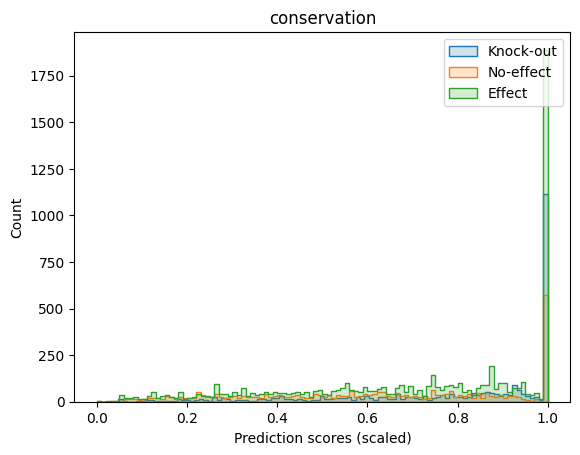

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(result_df, out_dir, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    if n_samples is not None:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    # print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"{out_dir}{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
out_dir="models/aa_common/pred_scores_distribution_plots_pmd_human_analysis/"
n_samples=None
is_dbnsfp_ok = True

# df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
# out_dir="models/aa_common/pred_scores_distribution_plots_pmd_nonhuman_analysis/"
# n_samples=3000
# is_dbnsfp_ok = False

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "sift_snpdbe"
    if model_root=="dbnsfp" and not is_dbnsfp_ok: continue
    
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        df[model_pred_col] = [random.uniform(0,1) for i in range(df.shape[0])]

    df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df = df[~pd.isna(df[model_pred_col])]  # taking df for only non-NAN values
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df, out_dir, n_samples)
    # break



	AUC-PR: 0.361
(25873,)
	Best F1-Score: 0.655 at threshold: 0.000
(25868,)
[0.48721607 0.4871963  0.48717652 ... 0.14285714 0.16666667 1.        ]
[1.00000000e+00 9.99920849e-01 9.99841697e-01 ... 7.91514960e-05
 7.91514960e-05 0.00000000e+00]


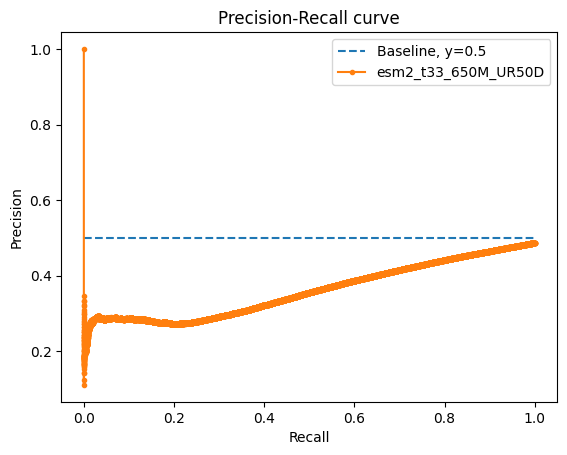

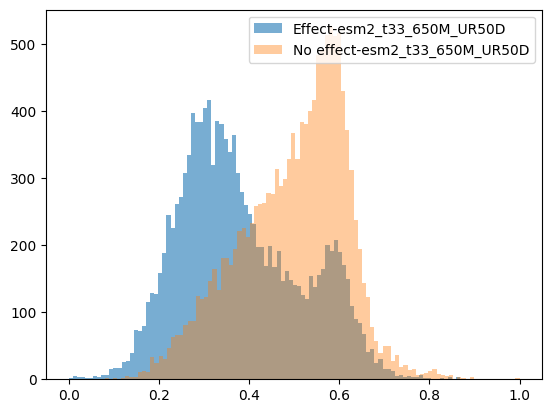

In [7]:

    

model_name = "esm2_t33_650M_UR50D"
model_pred_col = model_name + "_pred"

result_df.loc[result_df["functional_effect"]=="Effect", "class_numeric"] = 1
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 0

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
print(thresholds.shape)
print(precisions, recalls, sep="\n")

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


effect = result_df[result_df["functional_effect"]=="Effect"]
no_effect = result_df[result_df["functional_effect"]=="No effect"]

bins = 100 # 20, 100, 500
plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Effect-{model_name}")
plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No effect-{model_name}")

plt.legend()
plt.show()